# Introduction
This is the file that runs the model 1 time, and gives an overview of some of the output variables. Different plots are created, with different axes (year, month, 2014-2040), so Deltares can see all the possibilities. 

In [1]:
from Model3 import RiverDeltaModel
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
import copy

import matplotlib.lines as mlines

c:\Users\sjuul\anaconda3\envs\afstuderen2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")

model = RiverDeltaModel()

initial_model_state = copy.deepcopy(model) 

for j in range(300):
    model.step()

There are 0 agents unassigned!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!


In [3]:
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

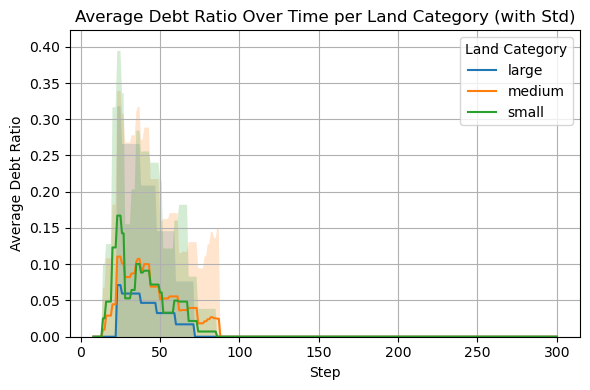

In [4]:
# Select the correct dataset
debt_data = agent_data
# Fill in the NaN values
debt_data = debt_data[debt_data['Debt ratio'].notna()]
import matplotlib.pyplot as plt

# Calculate average debt ratio, and the std dev
grouped = debt_data.groupby(['Step', 'Land_category'])['Debt ratio']
mean_debt = grouped.mean().unstack()
std_debt = grouped.std().unstack()

# Plot
plt.figure(figsize=(6, 4))

for category in mean_debt.columns:
    plt.plot(mean_debt.index, mean_debt[category], label=category)
    plt.fill_between(
        mean_debt.index,
        mean_debt[category] - std_debt[category],
        mean_debt[category] + std_debt[category],
        alpha=0.2
    )

plt.title("Average Debt Ratio Over Time per Land Category (with Std)")
plt.xlabel("Step")
plt.ylabel("Average Debt Ratio")
plt.ylim(bottom=0)
plt.legend(title="Land Category")
plt.grid(True)
plt.tight_layout()
plt.show()


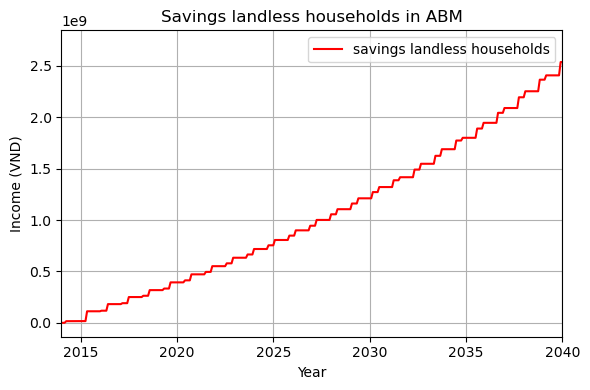

In [5]:
savings_landless = model_data.copy()
years = savings_landless.index / 12 + 2014  # Set to years instead of months

plt.figure(figsize=(6, 4))

plt.plot(years, savings_landless['Savings_landless_hh'], label='savings landless households', color='red')

plt.xlabel('Year')
plt.ylabel('Income (VND)')
plt.title('Savings landless households in ABM')
plt.xlim(2014, 2040)  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

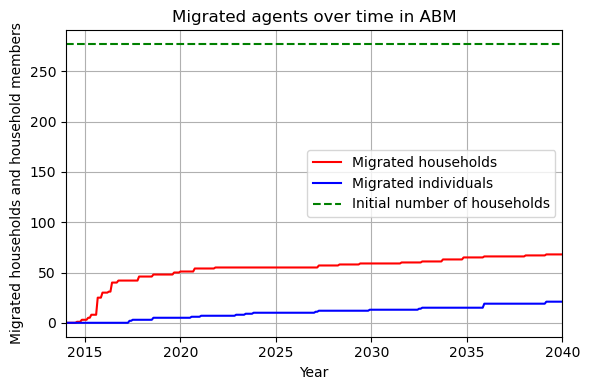

In [6]:
debt_model_data = model_data.copy()
years = debt_model_data.index / 12 + 2014  #Set to years instead of months

# look at the start number of households, to see the proportion of households migrated
start_households = model.start_households  

plt.figure(figsize=(6, 4))

plt.plot(years, debt_model_data['Migrated_households'], label='Migrated households', color='red')
plt.plot(years, debt_model_data['Migrated_individuals'], label='Migrated individuals', color='blue')

plt.axhline(y=start_households, color='green', linestyle='--', label='Initial number of households')

plt.xlabel('Year')
plt.ylabel('Migrated households and household members')
plt.title('Migrated agents over time in ABM')
plt.xlim(2014, 2040) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



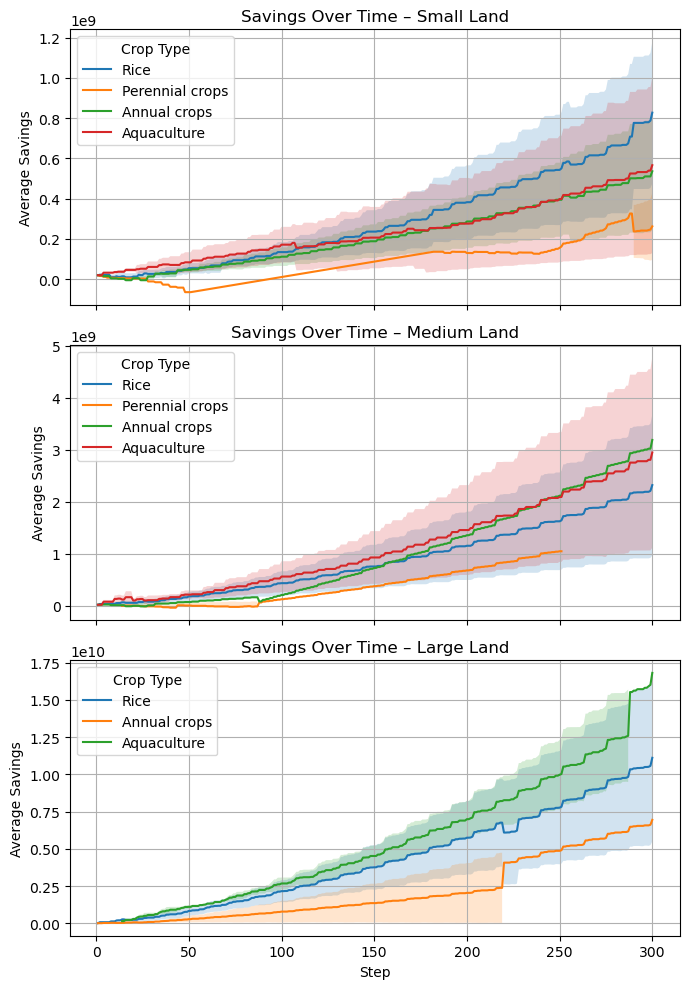

In [7]:
import numpy as np

# Select correct data and variables
df_savings = agent_data
df_filtered = df_savings.dropna(subset=['Crop_type', 'Land_category', 'Savings'])

# Set land categories and crop types
land_categories = ['small', 'medium', 'large']
crop_types = ['Rice', 'Perennial crops', 'Annual crops', 'Aquaculture']

# Create three subplots in 1 figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10), sharex=True)

# For each land category, do the following:
# -select the land category
# - look per crop type at the savings of households who have this crop_type, and take the mean value and std.dev
# - plot these savings over time
for i, land in enumerate(land_categories):
    ax = axes[i]
    df_land = df_filtered[df_filtered['Land_category'] == land]
    
    for crop in crop_types:
        df_crop = df_land[df_land['Crop_type'] == crop]
        if df_crop.empty:
            continue

        grouped = df_crop.groupby('Step')['Savings']
        mean = grouped.mean()
        std = grouped.std()

        ax.plot(mean.index, mean.values, label=crop)
        ax.fill_between(
            mean.index,
            np.maximum(0, mean - std),  
            mean + std,
            alpha=0.2
        )
    
    ax.set_title(f"Savings Over Time – {land.capitalize()} Land")
    ax.set_ylabel("Average Savings")
    ax.grid(True)
    ax.legend(title="Crop Type")

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()



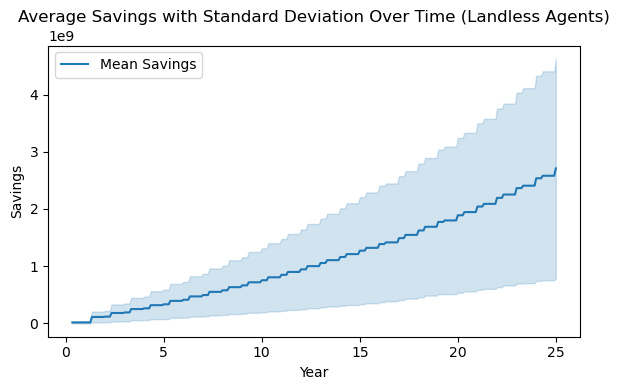

In [8]:
import seaborn as sns
# Filter landless agents 
landless_savings = agent_data[agent_data['too low income'].notna()].reset_index()
landless_savings['Year'] = landless_savings['Step'] / 12 # Set it to year instead of month


# Plot the savings over time
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=landless_savings,
    x="Year",
    y="Savings",
    errorbar='sd',  
    estimator="mean",
    label="Mean Savings",
    ci="sd"  
)

plt.title("Average Savings with Standard Deviation Over Time (Landless Agents)")
plt.xlabel("Year")
plt.ylabel("Savings")
plt.tight_layout()
plt.show()



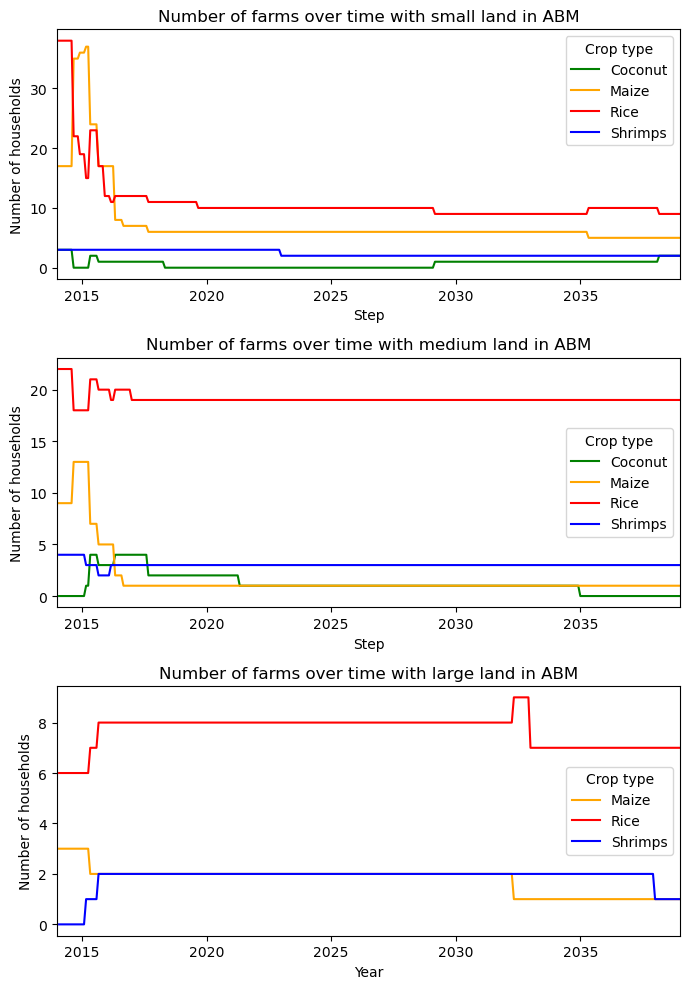

In [9]:
agent_data_crops_per_land = agent_data[agent_data['Crop_type'].notna()]
agent_data_crops_per_land

crop_colors = {
    "Maize": "orange",       
    "Rice": "red",
    "Coconut": "green",     
    "Shrimps": "blue"       
}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))

start_year = 2014
end_year = start_year + 25

for i, category in enumerate(['small', 'medium', 'large']):
    subsets = agent_data_crops_per_land[agent_data_crops_per_land["Land_category"] == category]
    if len(subsets) > 0:
        subsets = subsets.reset_index()
        subsets = subsets.groupby(['Step', "Crop_type"]).size().reset_index(name="count")
        subsets = subsets.pivot(index="Step", columns="Crop_type", values="count").fillna(0)

    
        rename_dict = {
            "Annual crops": "Maize",
            "Perennial crops": "Coconut",
            "Aquaculture": "Shrimps"
        }
        subsets.rename(columns=rename_dict, inplace=True)

        subsets.index = start_year + subsets.index / 12

      
        ordered_labels = ['Coconut', 'Maize', 'Rice', 'Shrimps']
        plot_columns = [label for label in ordered_labels if label in subsets.columns]
        color_list = [crop_colors[label] for label in plot_columns]

       
        subsets[plot_columns].plot(ax=axes[i], color=color_list)

      
        axes[i].set_title(f"Number of farms over time with {category} land in ABM")
        axes[i].set_ylabel("Number of households")
        axes[i].set_xlim(start_year, end_year)
        axes[i].grid(False)
       
        handles, _ = axes[i].get_legend_handles_labels()
        ordered_handles = [handles[plot_columns.index(label)] for label in plot_columns]
        axes[i].legend(ordered_handles, plot_columns, title="Crop type")

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()



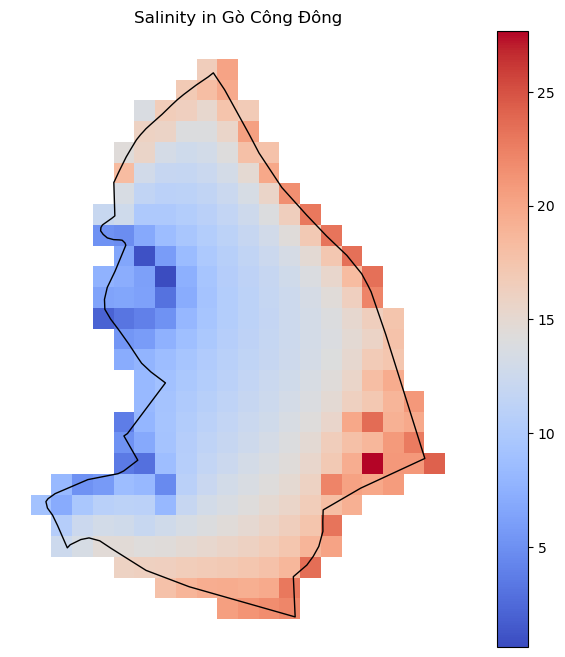

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
model.polygon_districts.boundary.plot(ax=ax, color='black', linewidth=1)
model.data_salinity.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title(f"Salinity in {model.district}")
plt.axis("off")
plt.show()

Aantal nodes per crop_type:
Annual crops: 29
Aquaculture: 7
Rice: 66
Perennial crops: 3
Unknown: 0
Aantal nodes per crop_type:
Annual crops: 7
Aquaculture: 6
Rice: 35
Perennial crops: 2
Unknown: 0


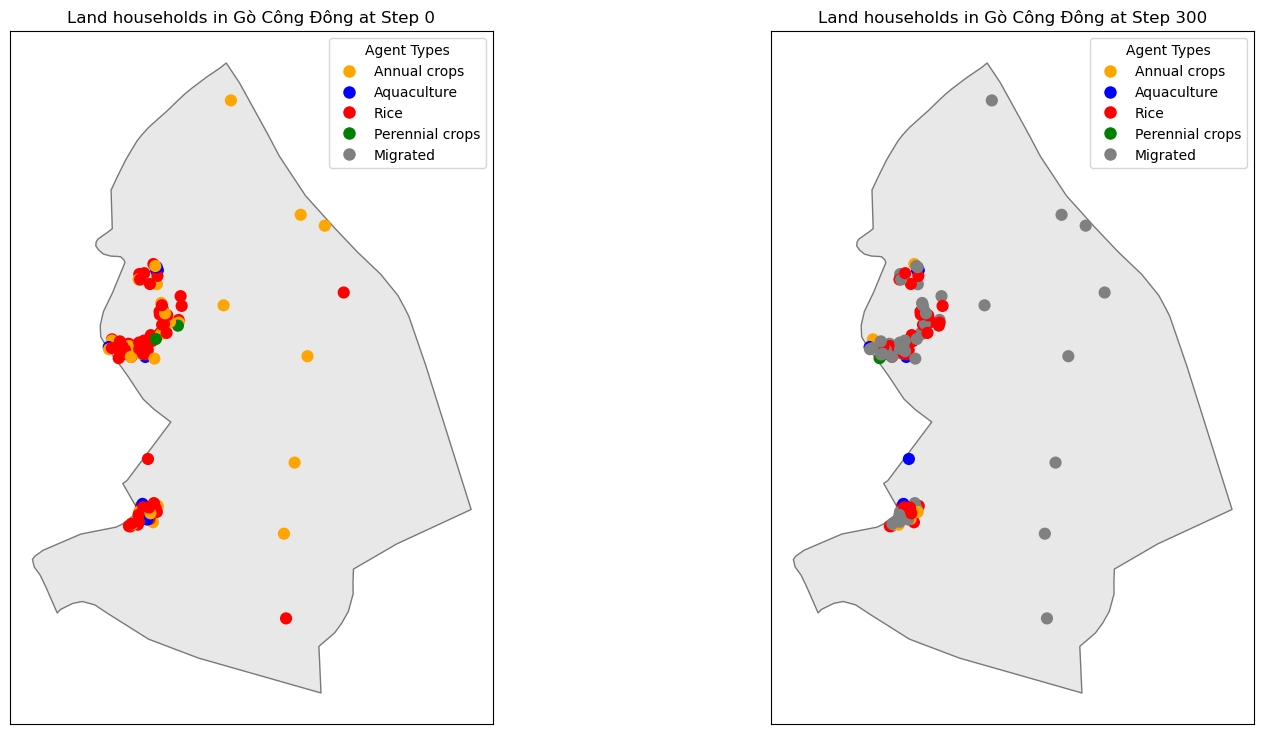

In [11]:
from Model3 import Large_land_households, Middle_land_households, Small_land_households
from collections import Counter

def plot_network(ax, model):
    ax.clear()

    # Map node_id to agent
    node_to_agent = {agent.node_id: agent for agent in model.agents if isinstance(agent, (Large_land_households, Middle_land_households, Small_land_households))}
    
    # Tellen crop_types
    crop_counts = Counter()
    for agent in node_to_agent.values():
        crop = agent.crop_type
        if crop is not None:
            crop_counts[crop] += 1
        else:
            crop_counts['Unknown'] += 1

    print("Aantal nodes per crop_type:")
    for crop_type in ["Annual crops", "Aquaculture", "Rice", "Perennial crops", "Unknown"]:
        print(f"{crop_type}: {crop_counts.get(crop_type, 0)}")

    # Plot district map
    model.polygon_districts.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    # Get node positions
    pos = nx.get_node_attributes(model.G, 'pos')

    # Prepare lists for nodes and their colors
    nodes_to_draw = []
    colors_to_draw = []

    for node_id in model.G.nodes():
        nodes_to_draw.append(node_id)
        agent = node_to_agent.get(node_id)
        if agent:
            if agent.crop_type == "Annual crops":
                colors_to_draw.append('orange')
            elif agent.crop_type == "Aquaculture":
                colors_to_draw.append('blue')
            elif agent.crop_type == "Rice":
                colors_to_draw.append('red')
            elif agent.crop_type == "Perennial crops":
                colors_to_draw.append('green')
            else:
                colors_to_draw.append("gray")  # unknown crop
        else:
            colors_to_draw.append("gray")  # migrated / no agent


    # Draw nodes with matching colors
    nx.draw_networkx_nodes(model.G, pos,
                           nodelist=nodes_to_draw,
                           node_color=colors_to_draw,
                           node_size=60,
                           ax=ax)

    # Add legend
    blue_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Annual crops')
    green_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Aquaculture')
    yellow_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Rice')
    red_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='green', markersize=10, label='Perennial crops')
    grey_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Migrated')
    ax.legend(handles=[blue_patch, green_patch, yellow_patch, red_patch, grey_patch], loc='upper right', title='Agent Types')

    ax.set_title(f"Land households in {model.district} at Step {model.steps}", fontsize=12)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 9))
plot_network(ax1, initial_model_state)
plot_network(ax2, model)
plt.show()